### Preparing the data:

In [1]:
# !tar -xvf '/content/gdrive/MyDrive/lfw.tgz' -C '/content/gdrive/MyDrive/'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Modules:

In [3]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as tkl
import tensorflow as tf
from keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Input, Conv2D, UpSampling2D, BatchNormalization, Activation, Add, ZeroPadding2D, concatenate
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import cv2
from sklearn.model_selection import train_test_split
from skimage.util import random_noise
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import random
from itertools import chain

### Creating a list of file names:

In [4]:
source_path = '/content/drive/MyDrive/HighResolution/'

filenames = []
folder_names = ['62000', '63000', '64000', '65000', '66000', '67000', '68000', '69000']
# test = os.path.join(source_path, f'{folder_names[1]}')
# content = os.listdir(test)

# print(content)
for folder in folder_names:
  
    filenames.append(glob.glob(os.path.join(source_path, f'{folder}/*.png')))

filenames = list(chain.from_iterable(filenames))
random.shuffle(filenames)
print('Completed.')

Completed.


In [5]:
print(len(filenames))

8000


### Showing a sample:

/content/drive/MyDrive/HighResolution/67000/67136.png


Text(0.5, 1.0, 'Noisy')

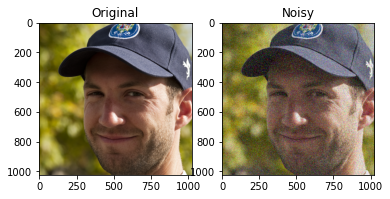

In [6]:
img_path = filenames[1000]
print(img_path)
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
noisy = random_noise(img, mode = 's&p', amount=0.2)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
ax[0].set_title('Original')
ax[1].imshow(noisy)
ax[1].set_title('Noisy')
# plt.imshow(noisy)

### Creating train set and test set:

In [7]:
test_filenames = filenames[-3001:-1]
del filenames[-3001:-1]
train_filenames = filenames
print(f'Size of training set is: {len(train_filenames)}', end='\n----------------------------\n')
print(f'Size of test set is: {len(test_filenames)}', end='\n----------------------------\n')

Size of training set is: 5000
----------------------------
Size of test set is: 3000
----------------------------


### Train set and validation set:

In [8]:
train_img, val_img, _, _ = train_test_split(train_filenames, train_filenames, test_size = 0.2, shuffle = True, random_state = 0)

In [9]:
print(f'Size of training set is: {len(train_img)}', end='\n----------------------------\n')
print(f'Size of validation set is: {len(val_img)}', end='\n----------------------------\n')
print(f'Total: {len(train_img) + len(val_img)}')

Size of training set is: 4000
----------------------------
Size of validation set is: 1000
----------------------------
Total: 5000


### Determining important variables:

In [10]:
WIDTH = 512
HEIGHT = 512
n_channels = 3
BATCH_SIZE = 32

### Data generation:

In [11]:
class  DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, orig_filenames, batch_size = BATCH_SIZE, shuffle = True):
        self.orig_filenames = orig_filenames
        self.noisy_filenames = orig_filenames
        self.filenames = list(zip(self.orig_filenames, self.noisy_filenames))
        self.batch_size = BATCH_SIZE
        self.shuffle = shuffle
    
    def __len__(self):
        return (len(self.orig_filenames) // self.batch_size)
    
    def __getitem__(self, idx):
        batch = self.filenames[idx * self.batch_size : (idx + 1) * self.batch_size]
        X, Y = self.__data_generation(batch)

        return X, Y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.orig_filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, batch):
        orig = []
        noisy = []
        
        for orig_file, _ in batch:
          image = cv2.imread(orig_file) / 255
          image = cv2.resize(image, (WIDTH, HEIGHT))
#           image = tf.image.convert_image_dtype(image, tf.float32)
          orig.append(image)
          noisy.append(self.make_noisy(image))
          
        return  np.array(noisy), np.array(orig)

    def make_noisy(self, image):
      image_ = image
      noisy_image = random_noise(image_, mode = 's&p', amount = 0.2)
      
      return noisy_image

### Generating training set and validation set:

In [12]:
train_generator = DataGenerator(train_img, BATCH_SIZE)
val_generator = DataGenerator(val_img, BATCH_SIZE)

### Creating the model architecture (U-net):

In [13]:
import tensorflow.keras.layers as tkl
def conv_block(inputs = None, n_filters = 32, kernel_size = 3, batch_norm = False):
    
    '''First layer'''
    
    conv = tkl.Conv2D(filters = n_filters,
                      kernel_size = kernel_size,
                      padding = 'same',
                      kernel_initializer = 'he_normal')(inputs)
    
    if batch_norm:
        conv = tkl.BatchNormalization()(conv)
    
    conv = tkl.Activation('relu')(conv)
    
    '''Second layer'''
    
    conv = tkl.Conv2D(filters = n_filters,
                     kernel_size = kernel_size,
                     padding = 'same',
                     kernel_initializer = 'he_normal')(conv)
    
    if batch_norm:
        conv = tkl.BatchNormalization()(conv)
    
    conv = tkl.Activation('relu')(conv)
        
    return conv


def conv_transpose_block(n_filters, kernel_size = 3):
    conv_transpose = tkl.Conv2DTranspose(n_filters, kernel_size = kernel_size, strides = (2,2), padding = 'same')
    
    return conv_transpose
    

def unet(n_filters = 32, dropout_prob = 0.1, batch_norm = True):
    input_size = (WIDTH, HEIGHT, n_channels)
    
    input_img = tf.keras.Input(input_size, name = 'image' )
    
    c1 = conv_block(input_img, n_filters / 2, kernel_size = 3)
    print('c1:', c1)
    p1 = tkl.MaxPooling2D((2,2))(c1)
    print('p1:', p1)
    p1 = tkl.Dropout(dropout_prob)(p1)
    
    c2 = conv_block(p1, n_filters, kernel_size = 3)
    print('c2:', c2)
    p2 = tkl.MaxPooling2D((2,2))(c2)
    print('p2:', p2)
    p2 = tkl.Dropout(dropout_prob)(p2)
    
    c3 = conv_block(p2, n_filters * 2, kernel_size = 3)
    print('c3:', c3)
    p3 = tkl.MaxPooling2D((2,2))(c3)
    print('p3:', p3)
    p3 = tkl.Dropout(dropout_prob)(p3)
    
    c4 = conv_block(p3, n_filters * 4, kernel_size = 3)
    print('c4:', c4)
    p4 = tkl.MaxPooling2D((2,2))(c4)
    print('p4:', p4)
    p4 = tkl.Dropout(dropout_prob)(p4)
    
    c5 = conv_block(p4, n_filters * 8 , kernel_size = 3)
    print('c5:', c5)
    p5 = tkl.MaxPooling2D((2,2))(c5)
    print('p5:', p5)
    p5 = tkl.Dropout(dropout_prob)(p5)

    c6 = conv_block(p5, n_filters * 16 , kernel_size = 3)
    print('c6:', c6)

    u6 = conv_transpose_block(n_filters * 8, kernel_size = 3)(c6)  #----> 32, 256
    print('u6:', u6)
    u6 = tkl.concatenate([u6, c5])     #----> 32, 256
    u6 = tkl.Dropout(dropout_prob)(u6)
    c7 = conv_block(u6, n_filters * 8, kernel_size = 3)   #----> 32, 256
    print('c7:', c7)
    
    u7 = conv_transpose_block(n_filters * 4)(c7)   #----> 64, 128
    print('u7:', u7)
    u7 = tkl.concatenate([u7, c4])   #----> 64, 128
    u7 = tkl.Dropout(dropout_prob)(u7)
    c8 = conv_block(u7, n_filters * 4, kernel_size = 3)   #----> 64, 128
    print('c8:', c8)
    
    u8 = conv_transpose_block(n_filters * 2, kernel_size = 3)(c8)   #----> 128, 64
    print('u8:', u8)
    u8 = tkl.concatenate([u8, c3])   #----> 128, 64
    u8 = tkl.Dropout(dropout_prob)(u8)
    c9 = conv_block(u8, n_filters * 2, kernel_size = 3)   #----> 128, 64
    print('c9:', c9)
    
    u9 = conv_transpose_block(n_filters, kernel_size = 3)(c9)   #----> 256, 32
    print('u9:', u9)
    u9 = tkl.concatenate([u9, c2])   #----> 256, 32
    u9 = tkl.Dropout(dropout_prob)(u9)
    c10 = conv_block(u9, n_filters , kernel_size = 3)   #----> 256, 32
    print('c10:', c10)

    u10 = conv_transpose_block(16, kernel_size=(3,3))(c10) #512, 16
    print('u10:', u10)
    u10 = tkl.concatenate([u10, c1])
    print('u10:', u10)
    u10 = tkl.Dropout(dropout_prob)(u10)

    c11 = conv_block(u10, n_filters / 2, (3,3))
    print('c11:', c11)

    output = tkl.Conv2D(3, (1,1), padding='same', activation='sigmoid')(c11)
    print(f'output shape is: {output}')
  

    return tf.keras.Model(inputs = [input_img], outputs = [output])

In [14]:
# def upsample(x, scale, num_filters):
#     def upsample_1(x, factor, **kwargs):
#         """Sub-pixel convolution."""
#         x = Conv2D(num_filters * (factor ** 2), 3, padding='same', **kwargs)(x)
#         return (pixel_shuffle(scale=factor))(x)

#     if scale == 2:
#         x = upsample_1(x, 2)
#     elif scale == 3:
#         x = upsample_1(x, 3)
#     elif scale == 4:
#         x = upsample_1(x, 4)

#     return x


# def pixel_shuffle(scale):
#     return lambda x: tf.nn.depth_to_space(x, scale)


#     ups1 = upsample(conv, 2, 256)
#     print('ups1:', ups1)
#     stack1 = concatenate([skip4, ups1])
#     # print(f'stack1: {stack1}')
#     # enc = tkl.Dropout(0.2)(stack1)
#     # enc = BatchNormalization()(conv)
#     enc = Conv2D(128, (3,3), padding='same')(stack1)
#     enc = Activation('relu')(enc)
#     # enc = tkl.Dropout(0.2)(enc)
#     enc = Conv2D(128, (3,3), padding='same')(enc)
#     enc = Activation('relu')(enc)
#     print(f'enc0: {enc}')

# # enc = Activation('relu')(enc)

# #2

#     ups2 = upsample(enc, 2, 64)
#     print('ups2:', ups2)
#     stack2 = concatenate([skip3, ups2])
#     # conv = tkl.Dropout(0.2)(ups2)
#     # enc = BatchNormalization()(conv)
#     enc = Conv2D(64, (3,3), padding='same')(stack2)
#     enc = Activation('relu')(enc)
#     enc = Conv2D(64, (3,3), padding='same')(enc)
#     # enc = Activation('relu')(enc)
#     enc = Activation('relu')(enc)
#     print('enc1:', enc)
#     #3

#     ups3 = upsample(enc, 2, 32)
#     print('ups3:', ups3)
#     stack3 = concatenate([skip2, ups3])
#     # enc = tkl.Dropout(0.2)(ups3)
#     # enc = BatchNormalization()(conv)
#     enc = Conv2D(32, (3,3), padding='same')(stack3)
#     enc = Activation('relu')(enc)
#     enc = Conv2D(32, (3,3), padding='same')(enc)
#     # enc = Activation('relu')(enc)
#     enc = Activation('relu')(enc)
#     print('enc2:', enc)
#     #4

#     ups4 = upsample(enc, 2, 16)
#     print('ups4:', ups4)
#     stack4 = concatenate([skip1, ups4])
#     # enc = BatchNormalization()(conv)
#     # enc = tkl.Dropout(0.2)(stack4)
#     enc = Conv2D(32, (3,3), padding='same')(stack4)
#     enc = Activation('relu')(enc)
#     # enc = tkl.Dropout(0.2)(enc)
#     enc = Conv2D(16, (3,3), padding='same')(enc)

#     # enc = Activation('relu')(enc)
#     # enc = Activation('relu')(enc)
#     print('enc3:', enc)
#     #5

#     ups5 = upsample(enc, 2, 16)
#     stack5 = concatenate([skip0, ups5])
#     # enc = tkl.Dropout(0.2)(stack5)
#     enc = Conv2D(3, (3,3), padding='same')(stack5)
#     enc = Activation('relu')(enc)
#     # enc = tkl.Dropout(0.2)(conv)
#     enc = Conv2D(3, (3,3), padding='same')(enc)
#     print('enc4:', enc)
#     enc = Activation('relu')(enc)
#     ups6 = upsample(enc, 2, 3)
#     print('ups6:', ups6)
#     output = Conv2D(3, (1,1), activation='sigmoid')(ups6)


In [15]:
model = unet()
model.summary()

c1: KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 16), dtype=tf.float32, name=None), name='activation_1/Relu:0', description="created by layer 'activation_1'")
p1: KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 16), dtype=tf.float32, name=None), name='max_pooling2d/MaxPool:0', description="created by layer 'max_pooling2d'")
c2: KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 32), dtype=tf.float32, name=None), name='activation_3/Relu:0', description="created by layer 'activation_3'")
p2: KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 32), dtype=tf.float32, name=None), name='max_pooling2d_1/MaxPool:0', description="created by layer 'max_pooling2d_1'")
c3: KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 64), dtype=tf.float32, name=None), name='activation_5/Relu:0', description="created by layer 'activation_5'")
p3: KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name=None), name='max_pooling2d_2/MaxPool:0', descripti

### Compiling the model:

In [16]:
adam = Adam(learning_rate = 0.003)
model.compile(optimizer = adam, loss = 'mse', metrics = ['accuracy'])

### Training the model:

In [ ]:
history = model.fit(train_generator,
                    validation_data = val_generator,
                    use_multiprocessing = True,
                    workers = 6, epochs=20)

Epoch 1/20


In [ ]:
model.save('DenoisingWithMoreSamples.h5')

In [35]:
# import tensorflow.keras.layers as tkl
# def conv_block(inputs = None, n_filters = 32, kernel_size = 3, batch_norm = True):
    
#     '''First layer'''
    
#     conv = tkl.Conv2D(filters = n_filters,
#                       kernel_size = kernel_size,
#                       padding = 'same',
#                       kernel_initializer = 'he_normal')(inputs)
    
#     if batch_norm:
#         conv = tkl.BatchNormalization()(conv)
    
#     conv = tkl.Activation('relu')(conv)
    
#     '''Second layer'''
    
#     conv = tkl.Conv2D(filters = n_filters,
#                      kernel_size = kernel_size,
#                      padding = 'same',
#                      kernel_initializer = 'he_normal')(conv)
    
#     if batch_norm:
#         conv = tkl.BatchNormalization()(conv)
    
#     conv = tkl.Activation('relu')(conv)
        
#     return conv


# def conv_transpose_block(n_filters, kernel_size = 3):
#     conv_transpose = tkl.Conv2DTranspose(n_filters, kernel_size = kernel_size, strides = (2,2), padding = 'same')
    
#     return conv_transpose
    

# def unet(n_filters = 32, dropout_prob = 0.1, batch_norm = True):
#     input_size = (WIDTH, HEIGHT, n_channels)
    
#     input_img = tf.keras.Input(input_size, name = 'image' )
    
#     c1 = conv_block(input_img, n_filters / 2, kernel_size = 3)
#     print('c1:', c1)
#     p1 = tkl.MaxPooling2D((2,2))(c1)
#     print('p1:', p1)
#     p1 = tkl.Dropout(dropout_prob)(p1)
    
#     c2 = conv_block(p1, n_filters, kernel_size = 3)
#     print('c2:', c2)
#     p2 = tkl.MaxPooling2D((2,2))(c2)
#     print('p2:', p2)
#     p2 = tkl.Dropout(dropout_prob)(p2)
    
#     c3 = conv_block(p2, n_filters * 2, kernel_size = 3)
#     print('c3:', c3)
#     p3 = tkl.MaxPooling2D((2,2))(c3)
#     print('p3:', p3)
#     p3 = tkl.Dropout(dropout_prob)(p3)
    
#     c4 = conv_block(p3, n_filters * 4, kernel_size = 3)
#     print('c4:', c4)
#     p4 = tkl.MaxPooling2D((2,2))(c4)
#     print('p4:', p4)
#     p4 = tkl.Dropout(dropout_prob)(p4)
    
#     c5 = conv_block(p4, n_filters * 8 , kernel_size = 3)
#     print('c5:', c5)
#     p5 = tkl.MaxPooling2D((2,2))(c5)
#     print('p5:', p5)
#     p5 = tkl.Dropout(dropout_prob)(p5)

#     c6 = conv_block(p5, n_filters * 16 , kernel_size = 3)
#     print('c6:', c6)

#     u6 = conv_transpose_block(n_filters * 8, kernel_size = 3)(c6)  #----> 32, 256
#     print('u6:', u6)
#     u6 = tkl.concatenate([u6, c5])     #----> 32, 256
#     u6 = tkl.Dropout(dropout_prob)(u6)
#     c7 = conv_block(u6, n_filters * 8, kernel_size = 3)   #----> 32, 256
#     print('c7:', c7)
    
#     u7 = conv_transpose_block(n_filters * 4)(c7)   #----> 64, 128
#     print('u7:', u7)
#     u7 = tkl.concatenate([u7, c4])   #----> 64, 128
#     u7 = tkl.Dropout(dropout_prob)(u7)
#     c8 = conv_block(u7, n_filters * 4, kernel_size = 3)   #----> 64, 128
#     print('c8:', c8)
    
#     u8 = conv_transpose_block(n_filters * 2, kernel_size = 3)(c8)   #----> 128, 64
#     print('u8:', u8)
#     u8 = tkl.concatenate([u8, c3])   #----> 128, 64
#     u8 = tkl.Dropout(dropout_prob)(u8)
#     c9 = conv_block(u8, n_filters * 2, kernel_size = 3)   #----> 128, 64
#     print('c9:', c9)
    
#     u9 = conv_transpose_block(n_filters, kernel_size = 3)(c9)   #----> 256, 32
#     print('u9:', u9)
#     u9 = tkl.concatenate([u9, c2])   #----> 256, 32
#     u9 = tkl.Dropout(dropout_prob)(u9)
#     c10 = conv_block(u9, n_filters , kernel_size = 3)   #----> 256, 32
#     print('c10:', c10)

#     u10 = conv_transpose_block(16, kernel_size=(3,3))(c10) #512, 16
#     print('u10:', u10)
#     u10 = tkl.concatenate([u10, c1])
#     print('u10:', u10)
#     u10 = tkl.Dropout(dropout_prob)(u10)

#     c11 = conv_block(u10, n_filters / 2, (3,3))
#     print('c11:', c11)

#     output = tkl.Conv2D(3, (1,1), padding='same', activation='sigmoid')(c11)
#     print(f'output shape is: {output}')
    
    
#     # output = tkl.Conv2D(3, (1,1), activation = 'sigmoid')(u10)

#     return tf.keras.Model(inputs = [input_img], outputs = [output])


    

In [37]:
# model = unet()